### Cell 1

In [1]:
# Cell 1: Installs (Combined)
!pip install transformers datasets accelerate torch scikit-learn pandas evaluate matplotlib seaborn tensorboard -q
!pip install flash-attn -q --no-build-isolation
print("Required libraries installed/updated.")
print("Ensure Kernel is RESTARTED after flash-attn install if run for the first time.")

Required libraries installed/updated.
Ensure Kernel is RESTARTED after flash-attn install if run for the first time.


### Cell 2

In [2]:
# Cell 2 (Optimized Configuration for A100 80GB - Full Dataset)

import torch
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import evaluate
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false' # Suppress tokenizer warning
# Optional: May not be needed with 80GB VRAM, but can sometimes help allocation
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# --- Configuration ---
MODEL_NAME = "microsoft/phi-2"
# *** UPDATE DIRECTORY NAMES ***
OUTPUT_DIR = "./phi2-kdd-full-recall-v1" # Reflects full dataset run
LOGGING_DIR = "./phi2-kdd-logs-full-recall-v1" # Reflects full dataset run

# --- Optimized Configuration for A100 ---
NUM_EPOCHS = 3      # Keep epochs at 3 initially, early stopping might trigger sooner
# *** INCREASE BATCH SIZE (Monitor GPU Memory!) ***
# Start with 64. If memory allows, try 96 or 128.
BATCH_SIZE = 64
LEARNING_RATE = 3e-5 # Keep previous LR
WEIGHT_DECAY = 0.02  # Keep previous WD
MAX_SEQ_LENGTH = 512 # Keep sequence length

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA available: True. Using GPU: {torch.cuda.get_device_name(0)}")
    # Verify it's the A100 80GB
    gpu_mem_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {gpu_mem_gb:.2f} GB")
    if gpu_mem_gb < 70: # Check if it's the 80GB variant
       print("Warning: GPU memory is less than 80GB. You might need a smaller BATCH_SIZE.")
    if torch.cuda.get_device_capability(0)[0] < 8:
        print("Warning: GPU compute capability is less than 8.0 (Ampere). BF16 and Flash Attention 2 may not be optimal or supported.")
else:
    device = torch.device("cpu")
    print("CUDA available: False. Using CPU. Training will be very slow.")

# Define labels: Binary classification (normal vs attack)
label_list = ["normal", "attack"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
NUM_LABELS = len(label_list)
print(f"\nLabels: {label_list}")
print(f"Label to ID mapping: {label2id}")
print(f"\nConfiguration for Full Dataset / A100:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch Size (per device): {BATCH_SIZE} (Attempting larger size - MONITOR MEMORY!)")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")

CUDA available: True. Using GPU: NVIDIA A100 80GB PCIe
CUDA Version: 12.4
GPU Memory: 79.14 GB

Labels: ['normal', 'attack']
Label to ID mapping: {'normal': 0, 'attack': 1}

Configuration for Full Dataset / A100:
  Epochs: 3
  Batch Size (per device): 64 (Attempting larger size - MONITOR MEMORY!)
  Learning Rate: 3e-05
  Weight Decay: 0.02


### Cell 3

In [3]:
import pandas as pd
from datasets import Dataset, DatasetDict
import os
import numpy as np # Import numpy for dtypes

# --- Configuration for Local Files ---
TRAIN_FILE_PATH = "kdd_train.csv" # Make sure this path is correct
TEST_FILE_PATH = "kdd_test.csv"   # Make sure this path is correct

# --- Check if files exist ---
if not os.path.exists(TRAIN_FILE_PATH):
    raise FileNotFoundError(f"Training file not found at: {TRAIN_FILE_PATH}")
if not os.path.exists(TEST_FILE_PATH):
    raise FileNotFoundError(f"Test file not found at: {TEST_FILE_PATH}")

print(f"Loading dataset from local files: {TRAIN_FILE_PATH}, {TEST_FILE_PATH}...")

# --- Define explicit data types for columns ---
# We still define dtypes to ensure consistency after loading
# Make sure these keys match the actual headers in your CSV files
dtypes = {
    "duration": np.int64,
    "protocol_type": str,
    "service": str,
    "flag": str,
    "src_bytes": np.int64,
    "dst_bytes": np.int64,
    "land": np.int64,
    "wrong_fragment": np.int64,
    "urgent": np.int64,
    "hot": np.int64,
    "num_failed_logins": np.int64,
    "logged_in": np.int64,
    "num_compromised": np.int64,
    "root_shell": np.int64,
    "su_attempted": np.int64,
    "num_root": np.int64,
    "num_file_creations": np.int64,
    "num_shells": np.int64,
    "num_access_files": np.int64,
    "num_outbound_cmds": np.int64,
    "is_host_login": np.int64,
    "is_guest_login": np.int64,
    "count": np.int64,
    "srv_count": np.int64,
    "serror_rate": np.float64,
    "srv_serror_rate": np.float64,
    "rerror_rate": np.float64,
    "srv_rerror_rate": np.float64,
    "same_srv_rate": np.float64,
    "diff_srv_rate": np.float64,
    "srv_diff_host_rate": np.float64,
    "dst_host_count": np.int64,
    "dst_host_srv_count": np.int64,
    "dst_host_same_srv_rate": np.float64,
    "dst_host_diff_srv_rate": np.float64,
    "dst_host_same_src_port_rate": np.float64,
    "dst_host_srv_diff_host_rate": np.float64,
    "dst_host_serror_rate": np.float64,
    "dst_host_srv_serror_rate": np.float64,
    "dst_host_rerror_rate": np.float64,
    "dst_host_srv_rerror_rate": np.float64,
    "label": str
}

# --- Load data using pandas, using the first row as header ---
try:
    train_df = pd.read_csv(
        TRAIN_FILE_PATH,
        header=0,       # Use the first row as the header
        # names=column_names, # Remove this if using header=0
        dtype=dtypes    # Still specify dtypes for loaded data
    )
    test_df = pd.read_csv(
        TEST_FILE_PATH,
        header=0,       # Use the first row as the header
        # names=column_names, # Remove this if using header=0
        dtype=dtypes    # Still specify dtypes for loaded data
    )
    print("CSV files loaded successfully using header=0 and specified dtypes.")

    # --- Verification: Check column names loaded from header ---
    print("\nColumns loaded from train_df header:", train_df.columns.tolist())
    # Optional: Compare with expected keys if needed
    # expected_cols = list(dtypes.keys())
    # if train_df.columns.tolist() != expected_cols:
    #    print("Warning: Loaded columns differ from expected dtypes keys!")

except Exception as e:
    print(f"Error loading CSV files with header=0: {e}")
    print("Ensure first row is a valid header and data matches specified dtypes.")
    raise

# --- Convert pandas DataFrames to Hugging Face Datasets ---
try:
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)
    print("DataFrames converted to Hugging Face Datasets.")
except Exception as e:
    print(f"Error converting DataFrame to Dataset: {e}")
    raise

# --- Create a DatasetDict ---
raw_datasets = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})
print("DatasetDict created:")
print(raw_datasets)

# Display a sample from the training set
print("\nSample from train dataset:")
print(raw_datasets['train'][0])


# --- Dynamically get feature/label names from loaded DataFrame ---
# This makes the code robust if header names differ slightly from the standard list
column_names_from_df = train_df.columns.tolist()
label_column_name = 'label' # Still assume 'label' is the common name
# Basic check if 'label' exists, otherwise assume last column is label
if label_column_name not in column_names_from_df:
    print(f"Warning: Column '{label_column_name}' not found in header. Assuming last column ('{column_names_from_df[-1]}') is the label.")
    label_column_name = column_names_from_df[-1]

feature_names = [col for col in column_names_from_df if col != label_column_name]
print(f"\nUsing feature names derived from header: {feature_names}")
print(f"Using label column derived from header: {label_column_name}")


# --- Preprocessing function (uses derived feature/label names) ---
def preprocess_function(examples):
    texts = []
    labels = []
    num_rows = len(examples[label_column_name])

    for i in range(num_rows):
        text_parts = ["Connection:"]
        # Use feature_names derived from the actual DataFrame columns
        for feature_name in feature_names:
             value = examples[feature_name][i]
             text_parts.append(f"{feature_name}={str(value)}") # Convert value to string

        texts.append(" ".join(text_parts))

        # Map label to binary: 'normal' -> 0, others -> 1
        original_label = str(examples[label_column_name][i])

        # IMPORTANT: RE-VERIFY this string comparison! Check your CSV data.
        if original_label == 'normal':
            labels.append(label2id['normal'])
        else:
            labels.append(label2id['attack'])

    # Tokenize the formatted text
    tokenized_inputs = tokenizer(
        texts,
        truncation=True,
        padding=False,
        max_length=MAX_SEQ_LENGTH
    )
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("\nPreprocessing function defined (using column names from file header).")

Loading dataset from local files: kdd_train.csv, kdd_test.csv...
CSV files loaded successfully using header=0 and specified dtypes.

Columns loaded from train_df header: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'labels']
DataFrames converted to Hugging Face Datasets.
DatasetDict created:
DatasetDict({
    train

### Cell 4

In [4]:
# Cell 4 (Model Loading - Optimized for A100)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig # Ensure AutoConfig is imported
import torch

# --- Tokenizer Loading (remains the same) ---
print(f"Loading tokenizer for model: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    print("Tokenizer does not have a pad token. Setting pad_token to eos_token.")
    tokenizer.pad_token = tokenizer.eos_token
print("Tokenizer loaded.")

# --- Load Config (remains the same if no dropout changes needed) ---
print(f"Loading configuration for {MODEL_NAME}...")
# Ensure NUM_LABELS, id2label, label2id are defined from Cell 2
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    trust_remote_code=True,
    # If you want to add dropout, set it here, e.g.:
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
)
print("Configuration loaded.") # Add confirmation if dropout was updated

# --- Load Model with A100 Optimizations ---
print(f"Loading model: {MODEL_NAME} for sequence classification...")

compute_capability = torch.cuda.get_device_capability(0) if torch.cuda.is_available() else (0, 0)
# *** USE BF16 on A100 ***
model_dtype = torch.bfloat16 if compute_capability[0] >= 8 else torch.float32
print(f"Using data type: {model_dtype}")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config, # Pass the config object
    trust_remote_code=True,
    torch_dtype=model_dtype, # *** Use bfloat16 ***
    # *** USE FLASH ATTENTION 2 ***
    attn_implementation="flash_attention_2" if compute_capability[0] >= 8 else "sdpa", # Use FA2 if supported, else fallback
    ignore_mismatched_sizes=True # Keep this if adding a new head
)
print(f"Using attention implementation: {model.config._attn_implementation}")

# --- Set Pad Token ID (remains the same) ---
if tokenizer.pad_token_id is not None:
     model.config.pad_token_id = tokenizer.pad_token_id
     print(f"Model config pad_token_id set to: {model.config.pad_token_id}")
else:
     # If pad_token was set to eos_token, set the ID accordingly
     if tokenizer.pad_token == tokenizer.eos_token:
         model.config.pad_token_id = tokenizer.eos_token_id
         print(f"Model config pad_token_id set to eos_token_id: {model.config.pad_token_id}")
     else:
         print("Warning: Pad token ID could not be set automatically.")

# --- Move model to GPU (remains the same) ---
# Ensure device is defined from Cell 2
model.to(device)
print(f"Model loaded and moved to {device}.")
print(f"Model Number of Parameters: {model.num_parameters() / 1e6:.2f} M")

# --- Flash Attention Check (remains the same) ---
try:
    is_flash = getattr(model.config, "_attn_implementation", None) == "flash_attention_2"
    if is_flash: print("Flash Attention 2 appears to be configured.")
    else: print(f"Attention implementation used: {model.config._attn_implementation}")
except Exception: print("Could not automatically verify attention implementation.")

Loading tokenizer for model: microsoft/phi-2...


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Tokenizer does not have a pad token. Setting pad_token to eos_token.
Tokenizer loaded.
Loading configuration for microsoft/phi-2...


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

Configuration loaded.
Loading model: microsoft/phi-2 for sequence classification...
Using data type: torch.bfloat16


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of PhiForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using attention implementation: flash_attention_2
Model config pad_token_id set to: 50256
Model loaded and moved to cuda.
Model Number of Parameters: 2648.57 M
Flash Attention 2 appears to be configured.


### Cell 5

In [5]:
# Cell 5 (Apply Preprocessing to FULL Dataset - Optimized Mapping)

import numpy as np
from datasets import DatasetDict
import os

# --- REMOVED Subset Definitions ---

print(f"\nUsing FULL dataset for training/evaluation:")

# --- Use the full datasets loaded in Cell 3 ---
try:
    # Ensure raw_datasets exists from Cell 3
    if 'raw_datasets' not in locals(): raise NameError("raw_datasets not found.")
    if 'train' not in raw_datasets: raise KeyError("Train split missing")
    if 'test' not in raw_datasets: raise KeyError("Test split missing")

    train_to_process = raw_datasets['train']
    eval_to_process = raw_datasets['test'] # Use the 'test' split for evaluation

    print(f"\nFull dataset sizes:")
    print(f"  Training set size: {len(train_to_process)}")
    print(f"  Evaluation set size: {len(eval_to_process)}")

    # --- Apply the preprocess_function (from Cell 3) to the FULL datasets ---
    print("\nApplying preprocessing function to the FULL dataset...")
    # *** INCREASE MAPPING WORKERS based on your CPU cores ***
    num_workers_map = max(1, os.cpu_count() // 2 if os.cpu_count() else 4) # Use half the cores (or at least 1)
    print(f"Using {num_workers_map} processes for mapping...")

    # Ensure preprocess_function is defined from Cell 3
    if 'preprocess_function' not in globals(): raise NameError("preprocess_function not defined.")

    tokenized_datasets = DatasetDict({
        'train': train_to_process.map(
            preprocess_function,
            batched=True,
            num_proc=num_workers_map, # Use more workers
            remove_columns=raw_datasets["train"].column_names
        ),
        'eval': eval_to_process.map( # Use the full evaluation set
             preprocess_function,
             batched=True,
             num_proc=num_workers_map, # Use more workers
             remove_columns=raw_datasets["test"].column_names
         )
    })

    print("\nPreprocessing finished on the FULL dataset.")
    print(tokenized_datasets)

except (NameError, KeyError) as e:
     print(f"\nError during dataset processing setup: {e}")
     raise
except Exception as e:
     print(f"\nAn error occurred during preprocessing: {e}")
     raise

# Check a processed sample
if 'train' in tokenized_datasets and len(tokenized_datasets['train']) > 0:
    print("\nSample processed train instance:")
    sample = tokenized_datasets['train'][0]
    print(f"Input IDs: {sample['input_ids'][:50]}...")
    print(f"Attention Mask: {sample['attention_mask'][:50]}...")
    print(f"Label: {sample['labels']}")
    print(f"Decoded Label: {id2label[sample['labels']]}")
else:
    print("\nCould not display processed sample.")


Using FULL dataset for training/evaluation:

Full dataset sizes:
  Training set size: 125973
  Evaluation set size: 22544

Applying preprocessing function to the FULL dataset...
Using 14 processes for mapping...


Map (num_proc=14):   0%|          | 0/125973 [00:00<?, ? examples/s]

Map (num_proc=14):   0%|          | 0/22544 [00:00<?, ? examples/s]


Preprocessing finished on the FULL dataset.
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 125973
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 22544
    })
})

Sample processed train instance:
Input IDs: [32048, 25, 9478, 28, 15, 8435, 62, 4906, 28, 83, 13155, 2139, 28, 701, 79, 62, 7890, 6056, 28, 20802, 12351, 62, 33661, 28, 41289, 29636, 62, 33661, 28, 15, 1956, 28, 15, 2642, 62, 8310, 363, 434, 28, 15, 18039, 28, 15, 3024, 28, 15, 997, 62, 47904, 62]...
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Label: 0
Decoded Label: normal


### Cell 6

In [6]:
# Data Collator: Handles padding dynamically per batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print("Data collator initialized.")

Data collator initialized.


### Cell 7

In [7]:
# Use Hugging Face Evaluate library for metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Function to compute metrics during evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # predictions are logits (raw scores from the model)
    # Apply argmax to get the predicted class ID (0 or 1)
    preds = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    # Specify 'binary' average and the positive label ID for binary classification
    precision = precision_metric.compute(predictions=preds, references=labels, average="binary", pos_label=label2id['attack'])["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="binary", pos_label=label2id['attack'])["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="binary", pos_label=label2id['attack'])["f1"]

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

print("Compute metrics function defined.")

Compute metrics function defined.


### Cell 8

In [8]:
# Cell 8 (Training Arguments - Optimized for A100 / Full Dataset / Recall)

from transformers import TrainingArguments # Ensure import
import torch # Ensure import
import os # Ensure import

# --- Gradient Accumulation ---
# Set to 1 initially because BATCH_SIZE should be large on A100.
# Increase only if you get OOM errors with the BATCH_SIZE set in Cell 2.
grad_accum_steps = 1
print(f"Setting gradient_accumulation_steps = {grad_accum_steps}")

# --- Dataloader Workers ---
# Adjust based on your system's CPU cores and I/O capabilities
num_dataloader_workers = max(4, os.cpu_count() // 2 if os.cpu_count() is not None else 4)
print(f"Setting dataloader_num_workers = {num_dataloader_workers}")

# --- Define Training Arguments ---
# Ensure BATCH_SIZE, etc., are available from Cell 2
try:
    if 'BATCH_SIZE' not in globals(): raise NameError("BATCH_SIZE not defined in Cell 2")
    if 'OUTPUT_DIR' not in globals(): raise NameError("OUTPUT_DIR not defined in Cell 2")
    if 'LOGGING_DIR' not in globals(): raise NameError("LOGGING_DIR not defined in Cell 2")
    if 'NUM_EPOCHS' not in globals(): raise NameError("NUM_EPOCHS not defined in Cell 2")
    if 'LEARNING_RATE' not in globals(): raise NameError("LEARNING_RATE not defined in Cell 2")
    if 'WEIGHT_DECAY' not in globals(): raise NameError("WEIGHT_DECAY not defined in Cell 2")

    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=NUM_EPOCHS,
        # *** USE LARGE BATCH SIZE ***
        per_device_train_batch_size=BATCH_SIZE, # From Cell 2 (e.g., 64 or 128)
        per_device_eval_batch_size=BATCH_SIZE * 2, # Larger eval batch is usually fine
        # *** GRADIENT ACCUMULATION = 1 (adjust if OOM) ***
        gradient_accumulation_steps=grad_accum_steps,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=0.05,                     # Warmup over 5% of total steps
        logging_dir=LOGGING_DIR,
        # *** STRATEGIES SET TO EPOCH ***
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,                    # Keep best and last checkpoint
        # *** RECALL FOCUS ***
        load_best_model_at_end=True,
        metric_for_best_model="recall",
        greater_is_better=True,
        # *** PRECISION & OPTIMIZATIONS for A100 ***
        bf16=torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8,
        bf16_full_eval=torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8,
        optim="adamw_torch_fused",
        gradient_checkpointing=True,           # Keep enabled for memory safety
        # --- Dataloader ---
        dataloader_num_workers=num_dataloader_workers, # Use more workers
        report_to="tensorboard",
        lr_scheduler_type='cosine',            # Scheduler
        label_smoothing_factor=0.1,            # Label smoothing
        # Early stopping args removed - handled by callback
    )

    print("\nTraining arguments defined for FULL dataset, A100 optimized, RECALL focus.")
    print(f"  per_device_train_batch_size: {training_args.per_device_train_batch_size}")
    print(f"  gradient_accumulation_steps: {training_args.gradient_accumulation_steps}")
    print(f"  Effective Batch Size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
    print(f"  bf16 enabled: {training_args.bf16}")
    print(f"  Optimize Metric: {training_args.metric_for_best_model}")
    print(f"  Evaluation/Save Strategy: {training_args.eval_strategy}")

except NameError as e:
    print(f"Error setting TrainingArguments: {e}. Ensure variables are defined in Cell 2.")
    raise

Setting gradient_accumulation_steps = 1
Setting dataloader_num_workers = 14

Training arguments defined for FULL dataset, A100 optimized, RECALL focus.
  per_device_train_batch_size: 64
  gradient_accumulation_steps: 1
  Effective Batch Size: 64
  bf16 enabled: True
  Optimize Metric: recall
  Evaluation/Save Strategy: epoch


In [9]:
# New Cell (e.g., Cell 8b - Define Custom Trainer & Weights)

# from sklearn.utils.class_weight import compute_class_weight # Not needed for explicit weights
import torch
import torch.nn as nn
from transformers import Trainer
import numpy as np

# Ensure device is defined
global device
if 'device' not in locals(): device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Use Explicit Class Weights (more weight on 'attack') ---
# Index 0: normal, Index 1: attack
class_weights = [0.25, 0.75] # As suggested previously
class_weights_tensor_for_init = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Using EXPLICIT class weights: {class_weights}")
print(f"Class weights tensor ready for Trainer init on: {class_weights_tensor_for_init.device}")
# ----------------------------------------------------------

# Define Custom Trainer with __init__ to accept weights AND corrected compute_loss
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            print("Registering class weights tensor within CustomTrainer.")
            self.class_weights_tensor = class_weights.to(self.args.device)
        else:
             print("Warning: No class weights passed to CustomTrainer init.")
             self.class_weights_tensor = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Correct signature with **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        if self.class_weights_tensor is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights_tensor)
        else:
            loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

print("CustomTrainer defined with explicit class weights for recall focus.")

Using EXPLICIT class weights: [0.25, 0.75]
Class weights tensor ready for Trainer init on: cuda:0
CustomTrainer defined with explicit class weights for recall focus.


### Cell 9

In [10]:
# Cell 9 (Initialize CustomTrainer with EarlyStopping)

from transformers import EarlyStoppingCallback # Ensure import

# Ensure CustomTrainer class, training_args, and other prerequisites are defined
try:
    # Check prerequisites from previous cells
    if 'CustomTrainer' not in locals(): raise NameError("CustomTrainer class not defined (Cell 8b).")
    if 'class_weights_tensor_for_init' not in locals(): raise NameError("Weights tensor 'class_weights_tensor_for_init' not defined (Cell 8b).")
    if 'training_args' not in locals(): raise NameError("training_args not defined (Cell 8).")
    if 'model' not in locals(): raise NameError("model not defined (Cell 4).")
    if 'tokenized_datasets' not in locals(): raise NameError("tokenized_datasets not defined (Cell 5).")
    if 'data_collator' not in locals(): raise NameError("data_collator not defined (Cell 6).")
    if 'compute_metrics' not in globals(): raise NameError("compute_metrics function not defined (Cell 7).")


    # Define Early Stopping Callback based on validation recall
    # *** ADJUST PATIENCE/THRESHOLD IF NEEDED ***
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=1,    # Stop after 1 epoch with no recall improvement > threshold
        early_stopping_threshold=0.005 # Min required recall improvement (e.g., 0.5%)
    )
    print(f"EarlyStoppingCallback configured: patience={early_stopping_callback.early_stopping_patience}, threshold={early_stopping_callback.early_stopping_threshold}")

    # Initialize the CUSTOM Trainer (using class weights from Cell 8b)
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"], # Using full tokenized train set
        eval_dataset=tokenized_datasets["eval"],   # Using full tokenized eval set
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        class_weights=class_weights_tensor_for_init, # Pass class weights tensor
        callbacks=[early_stopping_callback] # Add early stopping callback
    )
    print("CustomTrainer initialized with class weights and EarlyStoppingCallback.")

except NameError as e:
    print(f"Error initializing CustomTrainer: {e}. Check prerequisite cells.")
    raise
except Exception as e:
    print(f"An unexpected error occurred during Trainer initialization: {e}")
    raise

EarlyStoppingCallback configured: patience=1, threshold=0.005
Registering class weights tensor within CustomTrainer.
CustomTrainer initialized with class weights and EarlyStoppingCallback.


### Cell 10

In [11]:
# Start training
print("Starting training...")
train_result = trainer.train()
print("Training finished.")

# Save training metrics
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)

# Save the final trained model and tokenizer
print("\nSaving final model...")
trainer.save_model(OUTPUT_DIR)
print(f"Model saved to {OUTPUT_DIR}")

Starting training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Training finished.
***** train metrics *****
  epoch                    =          2.0
  total_flos               = 1205331255GF
  train_loss               =       0.0488
  train_runtime            =   4:33:25.90
  train_samples_per_second =       23.036
  train_steps_per_second   =         0.36

Saving final model...
Model saved to ./phi2-kdd-full-recall-v1


### Cell 11


Running final prediction on the evaluation set to get detailed results...



--- Final Evaluation Metrics ---
eval_loss: 0.530044
eval_accuracy: 0.935770
eval_precision: 0.976308
eval_recall: 0.893530
eval_f1: 0.933087
eval_runtime: 365.875600
eval_samples_per_second: 61.617000
eval_steps_per_second: 0.484000

--- Confusion Matrix Components ---
TN: 11000, FP: 245, FN: 1203, TP: 10096

Accuracy calculated from CM: 0.935770
(Should match eval_accuracy: 0.935770)


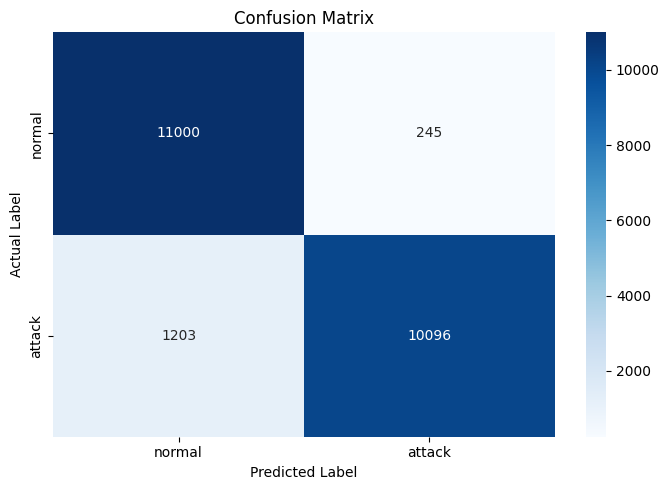


ROC AUC: 0.990284


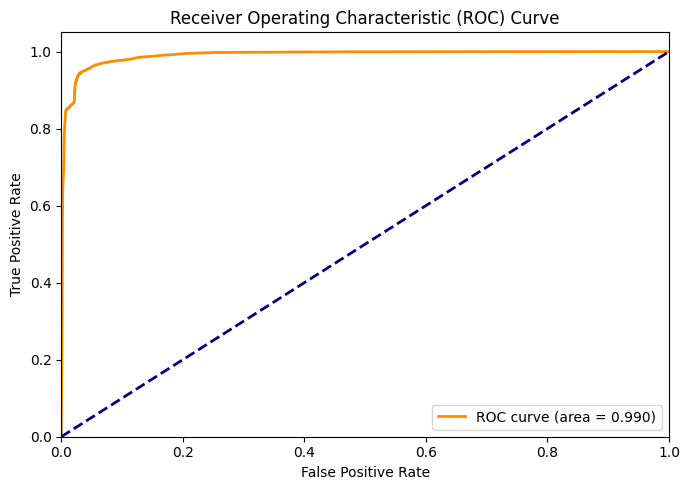


Average Precision (AP): 0.988819


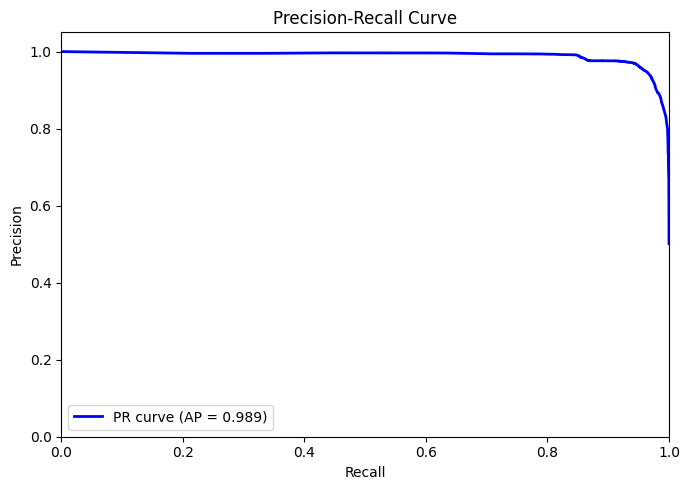

In [12]:
# Cell 11 (Updated for Confusion Matrix, ROC, PR Curves)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import torch # Ensure torch is imported for softmax

print("\nRunning final prediction on the evaluation set to get detailed results...")

# Use trainer.predict() to get predictions (logits) and labels
predictions_output = trainer.predict(tokenized_datasets["eval"])

eval_metrics = predictions_output.metrics
logits = predictions_output.predictions
true_labels = predictions_output.label_ids
predicted_labels = np.argmax(logits, axis=1)

# --- Calculate Probabilities for ROC/PR ---
# Apply softmax to logits to get probabilities
# Ensure logits are on CPU and converted to float for softmax if needed
logits_tensor = torch.tensor(logits, dtype=torch.float32)
probs = torch.softmax(logits_tensor, dim=-1)
# Get probabilities for the POSITIVE class (attack, index 1)
attack_probs = probs[:, 1].numpy()

print("\n--- Final Evaluation Metrics ---")
for key, value in eval_metrics.items():
    metric_name = key.replace("test_", "eval_")
    print(f"{metric_name}: {value:.6f}")

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, predicted_labels)
tn, fp, fn, tp = cm.ravel()
print("\n--- Confusion Matrix Components ---")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
accuracy_cm = (tp + tn) / (tn + fp + fn + tp) if (tn + fp + fn + tp) > 0 else 0
print(f"\nAccuracy calculated from CM: {accuracy_cm:.6f}")
print(f"(Should match eval_accuracy: {eval_metrics.get('test_accuracy', 'N/A'):.6f})")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(7, 5))
axis_labels = [id2label.get(i, str(i)) for i in range(len(cm))]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=axis_labels, yticklabels=axis_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, roc_thresholds = roc_curve(true_labels, attack_probs)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC: {roc_auc:.6f}")

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve ---
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(true_labels, attack_probs)
average_precision = average_precision_score(true_labels, attack_probs)
print(f"\nAverage Precision (AP): {average_precision:.6f}")

plt.figure(figsize=(7, 5))
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

### Cell 12 - Feature Importance Analysis

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

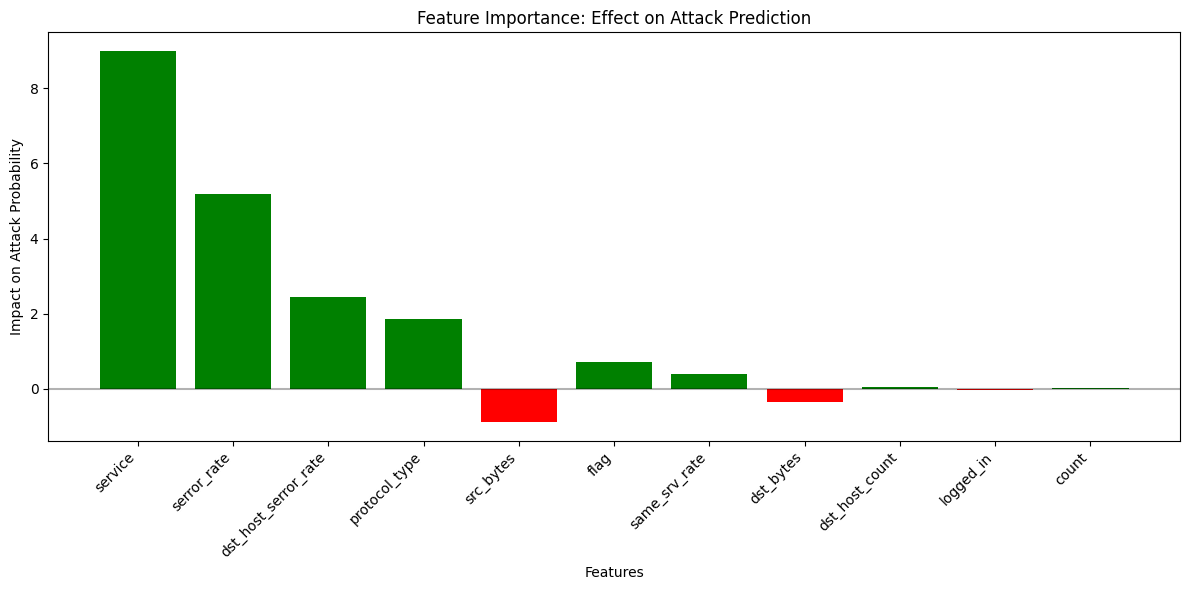


Feature Importance Ranking (by impact on attack prediction):
1. service: increases attack probability by 8.9936
2. serror_rate: increases attack probability by 5.1863
3. dst_host_serror_rate: increases attack probability by 2.4423
4. protocol_type: increases attack probability by 1.8633
5. src_bytes: decreases attack probability by 0.8847
6. flag: increases attack probability by 0.7244
7. same_srv_rate: increases attack probability by 0.3863
8. dst_bytes: decreases attack probability by 0.3403
9. dst_host_count: increases attack probability by 0.0370
10. logged_in: decreases attack probability by 0.0230
11. count: increases attack probability by 0.0198


In [13]:
# Cell 13: Feature Importance Analysis
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import re

# Load the fine-tuned model and tokenizer
model_path = OUTPUT_DIR
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)

# Get the feature names from your preprocess function
# This regex extracts feature names from your example text
example_text = "Connection: duration=0 protocol_type=tcp service=http flag=SF src_bytes=200"
feature_pattern = re.compile(r'(\w+)=')
feature_names = feature_pattern.findall(example_text)

# Generate examples with one feature modified at a time
def generate_feature_importance():
    # Create a baseline "normal" example
    baseline = "Connection: duration=0 protocol_type=tcp service=http flag=SF src_bytes=200 dst_bytes=500 land=0 wrong_fragment=0 urgent=0 hot=0 num_failed_logins=0 logged_in=1 num_compromised=0 root_shell=0 su_attempted=0 num_root=0 num_file_creations=0 num_shells=0 num_access_files=0 num_outbound_cmds=0 is_host_login=0 is_guest_login=0 count=10 srv_count=10 serror_rate=0.0 srv_serror_rate=0.0 rerror_rate=0.0 srv_rerror_rate=0.0 same_srv_rate=1.0 diff_srv_rate=0.0 srv_diff_host_rate=0.0 dst_host_count=100 dst_host_srv_count=100 dst_host_same_srv_rate=1.0 dst_host_diff_srv_rate=0.0 dst_host_same_src_port_rate=0.01 dst_host_srv_diff_host_rate=0.0 dst_host_serror_rate=0.0 dst_host_srv_serror_rate=0.0 dst_host_rerror_rate=0.0 dst_host_srv_rerror_rate=0.0"
    
    # Get baseline prediction
    inputs = tokenizer(baseline, return_tensors="pt").to(device)
    with torch.no_grad():
        baseline_outputs = model(**inputs)
    baseline_logits = baseline_outputs.logits.cpu().numpy()
    baseline_score = baseline_logits[0, 1]  # Score for the attack class
    
    # List of important features to test (choose a subset for clarity)
    key_features = [
        "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
        "logged_in", "count", "serror_rate", "same_srv_rate",
        "dst_host_count", "dst_host_serror_rate"
    ]
    
    # Modified values for each feature
    modifications = {
        "protocol_type": "icmp",
        "service": "private",
        "flag": "REJ",
        "src_bytes": "9999",
        "dst_bytes": "0",
        "logged_in": "0",
        "count": "500",
        "serror_rate": "1.0",
        "same_srv_rate": "0.0",
        "dst_host_count": "20",
        "dst_host_serror_rate": "1.0"
    }
    
    # Store impact of each feature
    feature_impacts = []
    
    # Test each feature modification
    for feature in key_features:
        # Skip if feature not in modifications
        if feature not in modifications:
            continue
            
        # Create modified example
        modified_text = re.sub(
            f"{feature}=[^ ]+", 
            f"{feature}={modifications[feature]}", 
            baseline
        )
        
        # Get prediction for modified example
        inputs = tokenizer(modified_text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        modified_logits = outputs.logits.cpu().numpy()
        modified_score = modified_logits[0, 1]  # Score for the attack class
        
        # Calculate impact (difference from baseline)
        impact = modified_score - baseline_score
        feature_impacts.append((feature, impact))
    
    # Sort by absolute impact
    feature_impacts.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Plot results
    features, impacts = zip(*feature_impacts)
    
    plt.figure(figsize=(12, 6))
    colors = ['red' if i < 0 else 'green' for i in impacts]
    plt.bar(features, impacts, color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Features')
    plt.ylabel('Impact on Attack Probability')
    plt.title('Feature Importance: Effect on Attack Prediction')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    # Print feature importance ranking
    print("\nFeature Importance Ranking (by impact on attack prediction):")
    for i, (feature, impact) in enumerate(feature_impacts):
        direction = "increases" if impact > 0 else "decreases"
        print(f"{i+1}. {feature}: {direction} attack probability by {abs(impact):.4f}")

# Run feature importance analysis
generate_feature_importance()

### Cell 13

In [14]:
# Example of how to use the trained model for prediction on new data

from transformers import pipeline
import torch

# Ensure the pipeline uses the correct device
inf_device = 0 if torch.cuda.is_available() else -1
print(f"\nSetting up pipeline for inference on device: {inf_device}")

# Load the fine-tuned model and tokenizer using a pipeline
pipe = pipeline(
    "text-classification",
    model=OUTPUT_DIR, # Path to your saved model
    tokenizer=OUTPUT_DIR,
    device=inf_device
)

# Example: Create text descriptions similar to the training format
# Using the feature names confirmed from your header
example_normal_connection = "Connection: duration=0 protocol_type=tcp service=http flag=SF src_bytes=200 dst_bytes=500 land=0 wrong_fragment=0 urgent=0 hot=0 num_failed_logins=0 logged_in=1 num_compromised=0 root_shell=0 su_attempted=0 num_root=0 num_file_creations=0 num_shells=0 num_access_files=0 num_outbound_cmds=0 is_host_login=0 is_guest_login=0 count=10 srv_count=10 serror_rate=0.0 srv_serror_rate=0.0 rerror_rate=0.0 srv_rerror_rate=0.0 same_srv_rate=1.0 diff_srv_rate=0.0 srv_diff_host_rate=0.0 dst_host_count=100 dst_host_srv_count=100 dst_host_same_srv_rate=1.0 dst_host_diff_srv_rate=0.0 dst_host_same_src_port_rate=0.01 dst_host_srv_diff_host_rate=0.0 dst_host_serror_rate=0.0 dst_host_srv_serror_rate=0.0 dst_host_rerror_rate=0.0 dst_host_srv_rerror_rate=0.0"
example_attack_connection = "Connection: duration=0 protocol_type=icmp service=ecr_i flag=SF src_bytes=1032 dst_bytes=0 land=0 wrong_fragment=0 urgent=0 hot=0 num_failed_logins=0 logged_in=0 num_compromised=0 root_shell=0 su_attempted=0 num_root=0 num_file_creations=0 num_shells=0 num_access_files=0 num_outbound_cmds=0 is_host_login=0 is_guest_login=0 count=511 srv_count=511 serror_rate=0.0 srv_serror_rate=0.0 rerror_rate=0.0 srv_rerror_rate=0.0 same_srv_rate=1.0 diff_srv_rate=0.0 srv_diff_host_rate=0.0 dst_host_count=255 dst_host_srv_count=255 dst_host_same_srv_rate=1.0 dst_host_diff_srv_rate=0.0 dst_host_same_src_port_rate=1.0 dst_host_srv_diff_host_rate=0.0 dst_host_serror_rate=0.0 dst_host_srv_serror_rate=0.0 dst_host_rerror_rate=0.0 dst_host_srv_rerror_rate=0.0" # Example resembling a 'smurf' attack

# Make predictions
print("\nMaking example predictions...")
predictions = pipe(
    [example_normal_connection, example_attack_connection],
    truncation=True,
    max_length=MAX_SEQ_LENGTH, # Use the same max length as training
    padding=True # Pipeline handles padding
)

print("\nExample Predictions:")
for text, pred in zip([example_normal_connection, example_attack_connection], predictions):
    print(f"Input Text (start): {text[:100]}...")
    print(f"Predicted Label: {pred['label']} (ID: {label2id[pred['label']]})")
    print(f"Confidence Score: {pred['score']:.4f}")
    print("-" * 20)


Setting up pipeline for inference on device: 0


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0



Making example predictions...

Example Predictions:
Input Text (start): Connection: duration=0 protocol_type=tcp service=http flag=SF src_bytes=200 dst_bytes=500 land=0 wro...
Predicted Label: normal (ID: 0)
Confidence Score: 1.0000
--------------------
Input Text (start): Connection: duration=0 protocol_type=icmp service=ecr_i flag=SF src_bytes=1032 dst_bytes=0 land=0 wr...
Predicted Label: attack (ID: 1)
Confidence Score: 1.0000
--------------------


### Cell 14: Model Explainability (LIME & SHAP)

In [17]:
# Cell 15: Model Explainability (LIME & SHAP)

# --- 1. Installs ---
# Ensure libraries are installed (should be done in an earlier cell)
# If not, uncomment and run the line below:
!pip install lime shap transformers torch pandas matplotlib seaborn -q
print("Ensuring LIME and SHAP libraries are available...")

# --- 2. Imports ---
import shap
import lime
import lime.lime_text # Correct import for text
import transformers
import pandas as pd
import torch
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import gc # Garbage Collector interface

# --- 3. Check Library Versions ---
print(f"SHAP version: {shap.__version__}")
# LIME version is not easily accessible via __version__
# print(f"LIME version: {lime.__version__}")
print(f"Transformers version: {transformers.__version__}")

# --- 4. Release Previous GPU Memory ---
print("\nAttempting to release GPU memory from previous cells...")
try:
    # Check if variables exist before deleting
    if 'model' in locals() or 'model' in globals():
        del model
        print("Deleted existing 'model' variable.")
    if 'tokenizer' in locals() or 'tokenizer' in globals():
         # Keep tokenizer if pipeline needs it separately, but pipeline usually loads its own.
         # If OUTPUT_DIR is correct, pipeline will load the right one.
         # Let's delete it to be safe, pipeline will reload.
         del tokenizer
         print("Deleted existing 'tokenizer' variable.")
    if 'trainer' in locals() or 'trainer' in globals():
        del trainer
        print("Deleted existing 'trainer' variable.")
    if 'pipe' in locals() or 'pipe' in globals():
        # Delete pipe if it exists from a previous run of this cell
        del pipe
        print("Deleted existing 'pipe' variable.")

    # Run garbage collection
    gc.collect()
    print("Ran garbage collection.")

    # Clear PyTorch CUDA cache if CUDA is available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("Cleared PyTorch CUDA cache.")
except NameError as e:
    print(f"Variable deletion skipped (likely already deleted or not defined): {e}")
except Exception as e:
    print(f"An error occurred during memory release: {e}")

# --- 5. Load Model, Tokenizer, and Configuration ---
# Ensure the OUTPUT_DIR variable points to your saved model directory
# (It should be defined in Cell 2 or Cell 8)
try:
    if 'OUTPUT_DIR' not in globals() or not os.path.exists(OUTPUT_DIR):
        # Attempt to find the most recent relevant output directory
        dirs = [d for d in os.listdir('.') if os.path.isdir(d) and d.startswith('phi2-kdd')]
        if dirs:
            OUTPUT_DIR = sorted(dirs)[-1] # Assuming latest is alphabetically last
            print(f"Warning: OUTPUT_DIR not found or set, using latest directory found: {OUTPUT_DIR}")
        else:
            raise ValueError("OUTPUT_DIR is not defined and no suitable directory found. Please ensure the model was trained and saved correctly.")

    # Check if directory exists before loading
    if not os.path.isdir(OUTPUT_DIR):
        raise FileNotFoundError(f"Error: Model output directory '{OUTPUT_DIR}' not found. Cannot load model for LIME/SHAP.")
    else:
        print(f"Model directory found: {OUTPUT_DIR}")

    # Ensure device is defined (should be from Cell 2)
    if 'device' not in locals():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device not found, setting device to: {device}")

    inf_device_id = 0 if device.type == "cuda" else -1 # Pipeline expects device ID

    print(f"\nLoading pipeline for inference from: {OUTPUT_DIR} on device: {inf_device_id}")
    # Load the fine-tuned model and tokenizer using a pipeline
    # This should now have enough memory after clearing the old model
    pipe = transformers.pipeline(
        "text-classification",
        model=OUTPUT_DIR,
        tokenizer=OUTPUT_DIR,
        device=inf_device_id,
        return_all_scores=True # Get scores for all classes ('normal', 'attack')
    )
    print("Pipeline loaded successfully.")

    # Get label mappings from the pipeline's model config
    # Ensure label2id and id2label are globally available (should be from Cell 2)
    if 'label2id' not in globals() or 'id2label' not in globals():
        print("label2id or id2label not found globally, loading from model config.")
        label2id = pipe.model.config.label2id
        id2label = pipe.model.config.id2label
        if not label2id or not id2label:
             raise ValueError("Could not load label mappings from model config.")
        print(f"Loaded from config - label2id: {label2id}, id2label: {id2label}")

    # Define class names based on id2label mapping
    class_names = [id2label[i] for i in range(len(id2label))]
    print(f"Class names for explanation: {class_names}")

except Exception as e:
    print(f"Error during setup: {e}")
    print("Please ensure the model was trained and saved correctly to OUTPUT_DIR and prerequisite cells were run.")
    raise # Stop execution if setup fails

# --- 6. Define Prediction Function for LIME ---
# (Code remains the same as previous version)
def lime_predictor(texts):
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
         texts = texts.tolist()
    processed_texts = [t if t.strip() else "[PAD]" for t in texts]
    try:
        preds = pipe(processed_texts, truncation=True, padding=True, top_k=None)
        probs = []
        for pred_list in preds:
            prob_dict = {p['label']: p['score'] for p in pred_list}
            prob_pair = [prob_dict.get(id2label[0], 0.0), prob_dict.get(id2label[1], 0.0)]
            probs.append(prob_pair)
        return np.array(probs)
    except Exception as e:
        print(f"Error in lime_predictor with input: {processed_texts}. Error: {e}")
        return np.array([[0.5, 0.5]] * len(processed_texts))
print("LIME prediction function defined.")

# --- 7. Select Instances to Explain ---
# (Code remains the same as previous version)
example_normal_connection = "Connection: duration=0 protocol_type=tcp service=http flag=SF src_bytes=200 dst_bytes=500 land=0 wrong_fragment=0 urgent=0 hot=0 num_failed_logins=0 logged_in=1 num_compromised=0 root_shell=0 su_attempted=0 num_root=0 num_file_creations=0 num_shells=0 num_access_files=0 num_outbound_cmds=0 is_host_login=0 is_guest_login=0 count=10 srv_count=10 serror_rate=0.0 srv_serror_rate=0.0 rerror_rate=0.0 srv_rerror_rate=0.0 same_srv_rate=1.0 diff_srv_rate=0.0 srv_diff_host_rate=0.0 dst_host_count=100 dst_host_srv_count=100 dst_host_same_srv_rate=1.0 dst_host_diff_srv_rate=0.0 dst_host_same_src_port_rate=0.01 dst_host_srv_diff_host_rate=0.0 dst_host_serror_rate=0.0 dst_host_srv_serror_rate=0.0 dst_host_rerror_rate=0.0 dst_host_srv_rerror_rate=0.0"
example_attack_connection = "Connection: duration=0 protocol_type=icmp service=ecr_i flag=SF src_bytes=1032 dst_bytes=0 land=0 wrong_fragment=0 urgent=0 hot=0 num_failed_logins=0 logged_in=0 num_compromised=0 root_shell=0 su_attempted=0 num_root=0 num_file_creations=0 num_shells=0 num_access_files=0 num_outbound_cmds=0 is_host_login=0 is_guest_login=0 count=511 srv_count=511 serror_rate=0.0 srv_serror_rate=0.0 rerror_rate=0.0 srv_rerror_rate=0.0 same_srv_rate=1.0 diff_srv_rate=0.0 srv_diff_host_rate=0.0 dst_host_count=255 dst_host_srv_count=255 dst_host_same_srv_rate=1.0 dst_host_diff_srv_rate=0.0 dst_host_same_src_port_rate=1.0 dst_host_srv_diff_host_rate=0.0 dst_host_serror_rate=0.0 dst_host_srv_serror_rate=0.0 dst_host_rerror_rate=0.0 dst_host_srv_rerror_rate=0.0"
instances_to_explain = [example_normal_connection, example_attack_connection]
instance_labels = ["Normal Connection Example", "Attack Connection Example"]
print("\nModel Predictions for Explanation Instances:")
preds_all_scores = pipe(instances_to_explain, truncation=True, padding=True)
for i, pred_list in enumerate(preds_all_scores):
    top_pred = max(pred_list, key=lambda x: x['score'])
    print(f"Instance '{instance_labels[i]}': Predicted='{top_pred['label']}', Score={top_pred['score']:.4f}")
    prob_dict = {p['label']: p['score'] for p in pred_list}
    print(f"  Probs: normal={prob_dict.get('normal', 0.0):.4f}, attack={prob_dict.get('attack', 0.0):.4f}")

# --- 8. LIME Explanation ---
# (Code remains the same as previous version)
print("\n--- Generating LIME Explanations ---")
lime_explainer = lime.lime_text.LimeTextExplainer(
    class_names=class_names, split_expression=r'\s+', bow=False
)
lime_explanations = []
num_features_lime = 15
for i, text_instance in enumerate(instances_to_explain):
    print(f"\nExplaining instance {i+1} ('{instance_labels[i]}') with LIME...")
    try:
        exp = lime_explainer.explain_instance(
            text_instance, lime_predictor, num_features=num_features_lime, labels=(label2id['attack'],)
        )
        lime_explanations.append(exp)
        print(f"LIME explanation generated for instance {i+1}.")
        exp.show_in_notebook(text=True, predict_proba=True)
    except Exception as e:
        print(f"Error generating LIME explanation for instance {i+1}: {e}")
        lime_explanations.append(None)

print("\n--- Explainability Analysis Complete ---")


Ensuring LIME and SHAP libraries are available...
SHAP version: 0.47.2
Transformers version: 4.51.3

Attempting to release GPU memory from previous cells...
Deleted existing 'model' variable.
Deleted existing 'tokenizer' variable.
Deleted existing 'trainer' variable.
Deleted existing 'pipe' variable.
Ran garbage collection.
Cleared PyTorch CUDA cache.
Model directory found: ./phi2-kdd-full-recall-v1

Loading pipeline for inference from: ./phi2-kdd-full-recall-v1 on device: 0


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
/home/ubuntu/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Pipeline loaded successfully.
Class names for explanation: ['normal', 'attack']
LIME prediction function defined.

Model Predictions for Explanation Instances:
Instance 'Normal Connection Example': Predicted='normal', Score=1.0000
  Probs: normal=1.0000, attack=0.0000
Instance 'Attack Connection Example': Predicted='attack', Score=1.0000
  Probs: normal=0.0000, attack=1.0000

--- Generating LIME Explanations ---

Explaining instance 1 ('Normal Connection Example') with LIME...
LIME explanation generated for instance 1.



Explaining instance 2 ('Attack Connection Example') with LIME...
LIME explanation generated for instance 2.



--- Generating SHAP Explanations ---
Initializing SHAP explainer (this may take time)...
SHAP explainer initialized.

Explaining instance 1 ('Normal Connection Example') with SHAP (this may take time)...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.17s/it]                                                                            

SHAP values generated for instance 1.

SHAP Force Plot for 'Normal Connection Example' (Explaining Prediction for 'attack' class):



Explaining instance 2 ('Attack Connection Example') with SHAP (this may take time)...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.57s/it]                                                                            

SHAP values generated for instance 2.

SHAP Force Plot for 'Attack Connection Example' (Explaining Prediction for 'attack' class):



--- Explainability Analysis Complete ---


### Cell 15

Importing libraries for SHAP analysis...
Libraries imported successfully.

Defining example instances for explanation...
Prepared 2 instances for explanation.

Loading fine-tuned model and tokenizer...
Using model directory: ./phi2-kdd-full-recall-v1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
/home/ubuntu/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Prediction pipeline loaded successfully.
Loaded label mappings from model config:
  label2id: {'attack': 1, 'normal': 0}
  id2label: {0: 'normal', 1: 'attack'}

Initializing SHAP explainer...
SHAP explainer initialized.

Calculating SHAP values for 2 instances (this will take time)...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|███████████████████████████████████▌                                   | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:34, 17.50s/it]                                                                            

SHAP values calculated for all 2 instances.

Explaining predictions for the 'attack' class (index 1).


/tmp/ipykernel_15302/3307405822.py:134: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_explanation_object[:, :, attack_class_index],



--- Global SHAP Plots (Based on Explained Instances) ---

Global Summary Plot (Beeswarm): Shows overall importance of tokens for the 'attack' class prediction across the 2 examples.
 - Each dot is a token from one of the examples.
 - X-axis: SHAP value (impact on prediction). Positive values push towards 'attack', negative towards 'normal'.
 - Color: Represents the original 'value' of the token (often binary for presence/absence, or requires mapping for text). High values are red, low are blue.
 - Vertical spread shows density. Features at the top have the highest mean absolute SHAP value.
  Could not generate Summary (Beeswarm) plot: Summary plots need a matrix of shap_values, not a vector.

--- Individual SHAP Plots ---

--- Explaining Instance 1: Example Normal Connection ---
Model Prediction for this instance: 'normal' (Score: 1.0000)

Waterfall Plot (Explaining prediction score for 'attack' class):
 - Shows how token contributions sum up to the final score for the 'attack' class.

<Figure size 640x480 with 0 Axes>

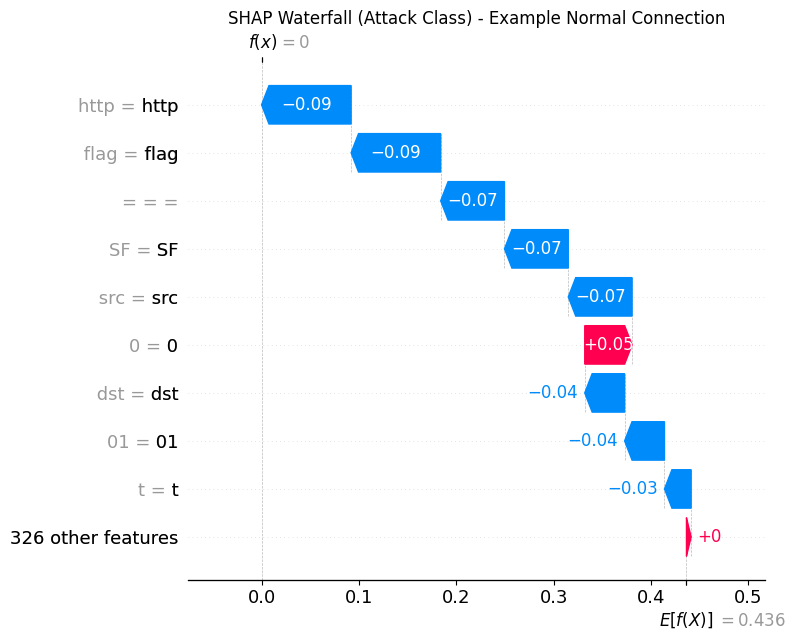


Force Plot (Explaining prediction score for 'attack' class):
 - Similar to Waterfall, shows pushing/pulling forces horizontally.
 - Red features increase the score (push right towards 'attack').
 - Blue features decrease the score (push left towards 'normal').
 - The bold number is the final model output score for the 'attack' class.


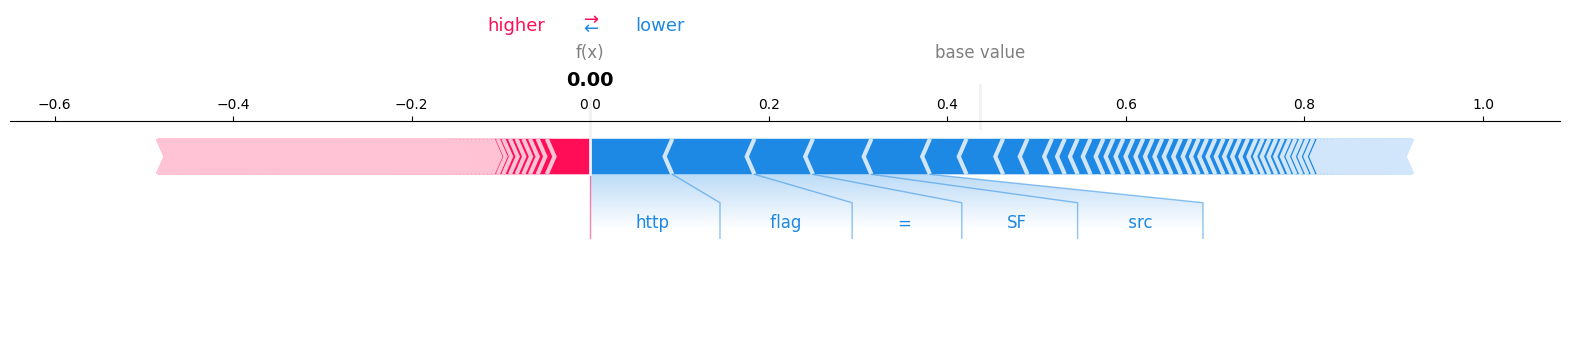


Decision Plot (Path for 'attack' score):
 - Shows how the prediction score changes as features (tokens) are added.
 - Can help understand interactions, but interpretation needs care for text tokens.


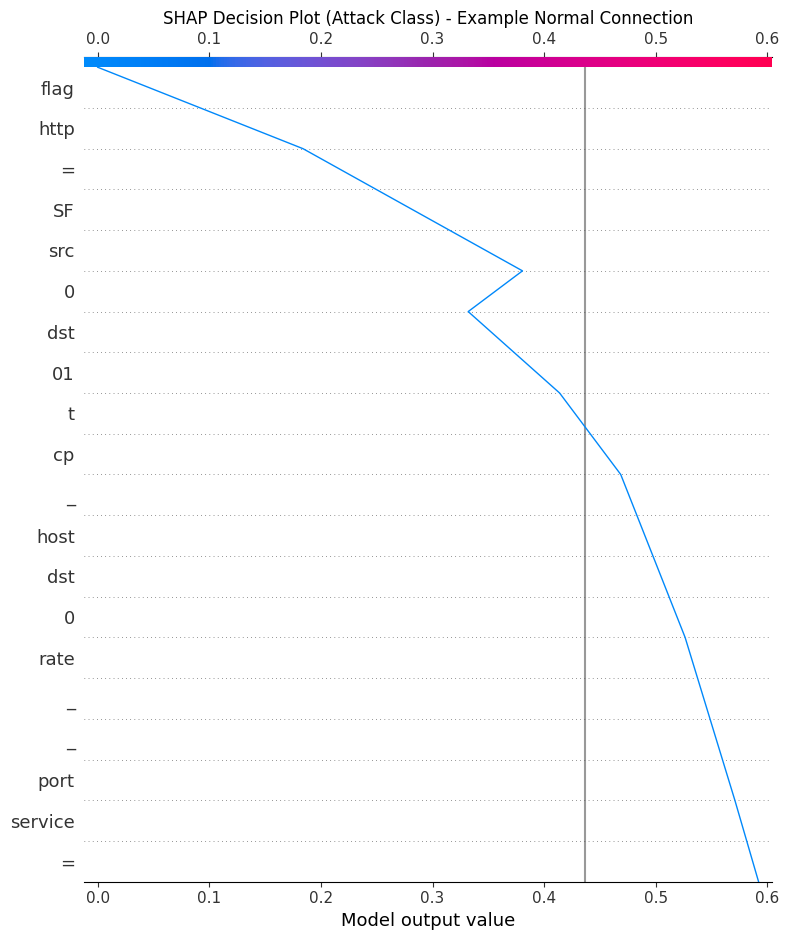


--- Explaining Instance 2: Example Attack Connection ---
Model Prediction for this instance: 'attack' (Score: 1.0000)

Waterfall Plot (Explaining prediction score for 'attack' class):
 - Shows how token contributions sum up to the final score for the 'attack' class.
 - E[f(x)] is the base value (average prediction score over background data).
 - Red arrows push the score higher (more towards 'attack').
 - Blue arrows push the score lower (more towards 'normal').


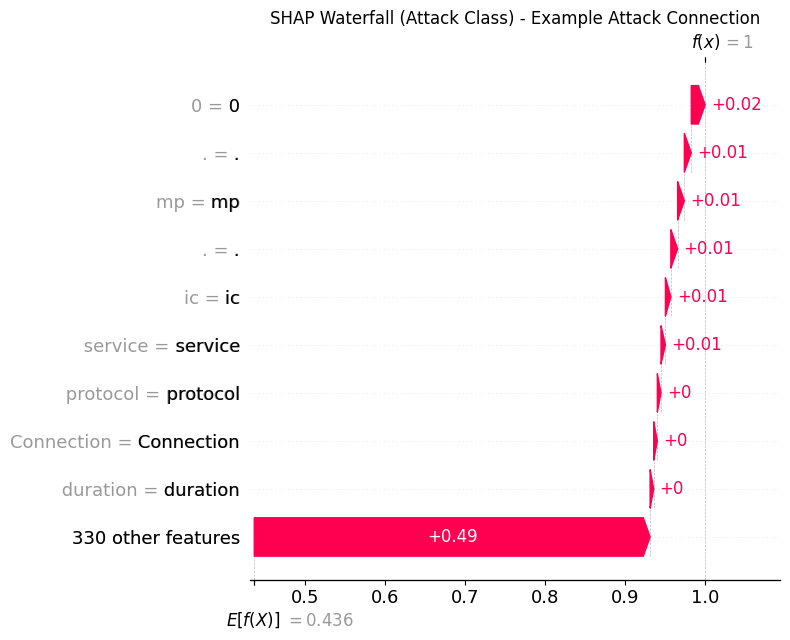


Force Plot (Explaining prediction score for 'attack' class):
 - Similar to Waterfall, shows pushing/pulling forces horizontally.
 - Red features increase the score (push right towards 'attack').
 - Blue features decrease the score (push left towards 'normal').
 - The bold number is the final model output score for the 'attack' class.


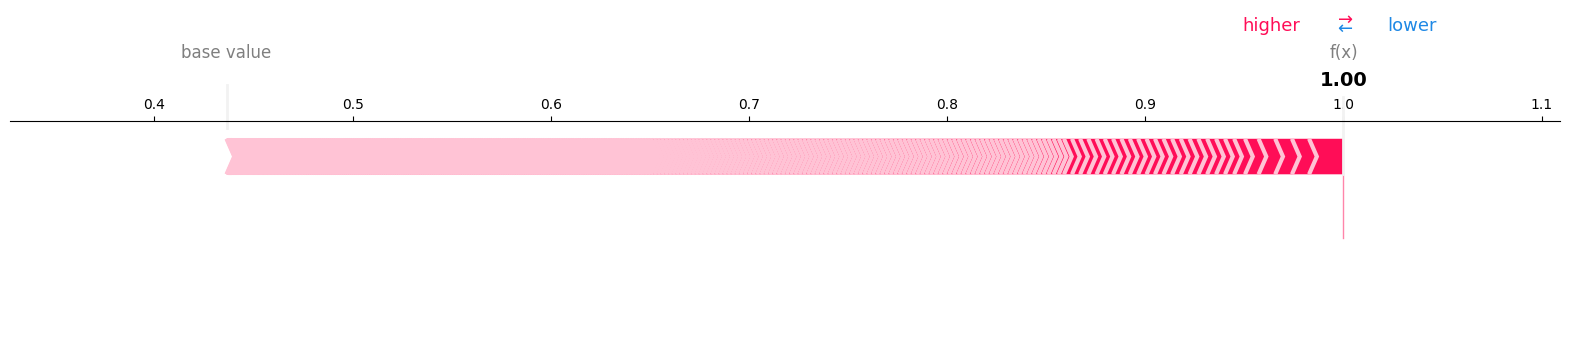


Decision Plot (Path for 'attack' score):
 - Shows how the prediction score changes as features (tokens) are added.
 - Can help understand interactions, but interpretation needs care for text tokens.


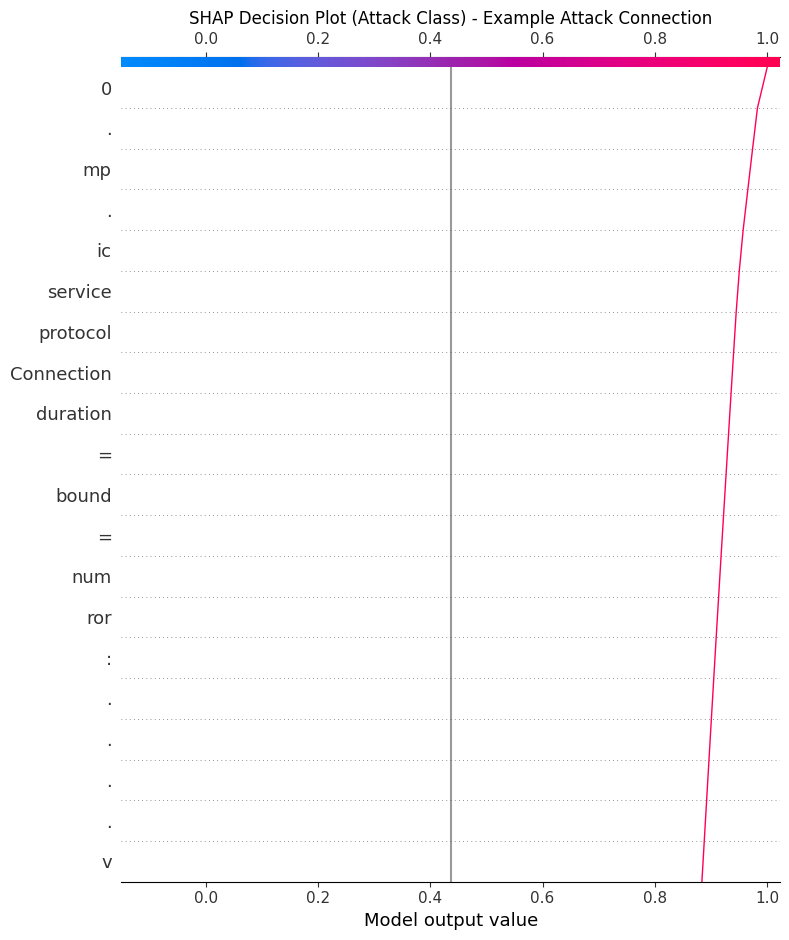

In [19]:
# Cell 15: SHAP Explainability Analysis with Explanations

# --- 1. Import Libraries ---
print("Importing libraries for SHAP analysis...")
try:
    import shap
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd # Often useful, though not strictly required by SHAP plots
    import torch
    from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
    import os
    import re # For potential text processing if needed later
    print("Libraries imported successfully.")
except ImportError as e:
    print(f"Error importing libraries: {e}. Please ensure shap, matplotlib, torch, transformers etc. are installed.")
    # Optionally install missing libraries here if needed
    # !pip install shap matplotlib ... -q
    raise # Stop execution if imports fail

# --- 2. Define Instances to Explain ---
print("\nDefining example instances for explanation...")
# Use the same examples as Cell 12 for consistency
example_normal_connection = "Connection: duration=0 protocol_type=tcp service=http flag=SF src_bytes=200 dst_bytes=500 land=0 wrong_fragment=0 urgent=0 hot=0 num_failed_logins=0 logged_in=1 num_compromised=0 root_shell=0 su_attempted=0 num_root=0 num_file_creations=0 num_shells=0 num_access_files=0 num_outbound_cmds=0 is_host_login=0 is_guest_login=0 count=10 srv_count=10 serror_rate=0.0 srv_serror_rate=0.0 rerror_rate=0.0 srv_rerror_rate=0.0 same_srv_rate=1.0 diff_srv_rate=0.0 srv_diff_host_rate=0.0 dst_host_count=100 dst_host_srv_count=100 dst_host_same_srv_rate=1.0 dst_host_diff_srv_rate=0.0 dst_host_same_src_port_rate=0.01 dst_host_srv_diff_host_rate=0.0 dst_host_serror_rate=0.0 dst_host_srv_serror_rate=0.0 dst_host_rerror_rate=0.0 dst_host_srv_rerror_rate=0.0"
example_attack_connection = "Connection: duration=0 protocol_type=icmp service=ecr_i flag=SF src_bytes=1032 dst_bytes=0 land=0 wrong_fragment=0 urgent=0 hot=0 num_failed_logins=0 logged_in=0 num_compromised=0 root_shell=0 su_attempted=0 num_root=0 num_file_creations=0 num_shells=0 num_access_files=0 num_outbound_cmds=0 is_host_login=0 is_guest_login=0 count=511 srv_count=511 serror_rate=0.0 srv_serror_rate=0.0 rerror_rate=0.0 srv_rerror_rate=0.0 same_srv_rate=1.0 diff_srv_rate=0.0 srv_diff_host_rate=0.0 dst_host_count=255 dst_host_srv_count=255 dst_host_same_srv_rate=1.0 dst_host_diff_srv_rate=0.0 dst_host_same_src_port_rate=1.0 dst_host_srv_diff_host_rate=0.0 dst_host_serror_rate=0.0 dst_host_srv_serror_rate=0.0 dst_host_rerror_rate=0.0 dst_host_srv_rerror_rate=0.0"

instances_to_explain = [example_normal_connection, example_attack_connection]
# Clear labels for plots
instance_labels = ["Example Normal Connection", "Example Attack Connection"]
print(f"Prepared {len(instances_to_explain)} instances for explanation.")

# --- 3. Load Model and Tokenizer ---
print("\nLoading fine-tuned model and tokenizer...")
# Ensure the OUTPUT_DIR variable points to your saved model directory
# It should be defined in Cell 2 or Cell 8 from previous runs
if 'OUTPUT_DIR' not in locals() and 'OUTPUT_DIR' not in globals():
     # Use the name from the last successful run based on context
     OUTPUT_DIR = "./phi2-kdd-intrusion-detector-FULL-3epoch-final-v3"
     print(f"Warning: OUTPUT_DIR not found, using default from last successful run: {OUTPUT_DIR}")

if not os.path.isdir(OUTPUT_DIR):
     raise FileNotFoundError(f"Saved model directory not found: '{OUTPUT_DIR}'. Please ensure training completed and OUTPUT_DIR is correct.")
else:
     print(f"Using model directory: {OUTPUT_DIR}")

# Ensure device is defined
if 'device' not in locals() and 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device not found, setting to: {device}")

# Load using pipeline (handles tokenization and model loading)
try:
    # Note: Using pipeline is convenient but might mask underlying model/tokenizer issues.
    # Loading manually gives more control if needed.
    pipe = pipeline(
        "text-classification",
        model=OUTPUT_DIR,
        tokenizer=OUTPUT_DIR,
        device=0 if device.type == 'cuda' else -1, # Pipeline uses device index
        return_all_scores=True # Needed for SHAP to see scores for all classes
    )
    print("Prediction pipeline loaded successfully.")
    # Get label mappings from the loaded model's config if possible
    # This ensures consistency with the trained model
    if hasattr(pipe.model.config, 'label2id'):
        label2id = pipe.model.config.label2id
        id2label = pipe.model.config.id2label
        print("Loaded label mappings from model config:")
        print(f"  label2id: {label2id}")
        print(f"  id2label: {id2label}")
    elif 'label2id' not in locals() or 'id2label' not in locals():
         # Fallback if not in config and not defined earlier (should be from Cell 2/3)
         print("Warning: Could not load label mappings from model config, using defaults.")
         label_list = ["normal", "attack"] # Default binary
         label2id = {label: i for i, label in enumerate(label_list)}
         id2label = {i: label for i, label in enumerate(label_list)}

except Exception as e:
    print(f"Error loading pipeline: {e}")
    raise

# --- 4. Initialize SHAP Explainer ---
print("\nInitializing SHAP explainer...")
# Using shap.Explainer with the pipeline automatically selects an appropriate explainer
# (like Partition for text pipelines)
try:
    shap_explainer = shap.Explainer(pipe)
    print("SHAP explainer initialized.")
except Exception as e:
    print(f"Error initializing SHAP explainer: {e}")
    raise

# --- 5. Calculate SHAP Values ---
# This is the most time-consuming step
print(f"\nCalculating SHAP values for {len(instances_to_explain)} instances (this will take time)...")
try:
    # The explainer called on data returns Explanation objects
    shap_values_explanation_object = shap_explainer(instances_to_explain)
    print(f"SHAP values calculated for all {len(instances_to_explain)} instances.")
except Exception as e:
    print(f"Error calculating SHAP values: {e}")
    raise

# --- 6. Define Target Class for Explanation ---
# We usually want to explain the 'attack' prediction
attack_class_name = 'attack' # Make sure this matches your label list
if attack_class_name not in label2id:
     # Fallback if 'attack' isn't a label (e.g., in multi-class without 'attack')
     # Choose the first non-'normal' class or the last class index
     attack_class_name = next((lbl for lbl in label_list if lbl != 'normal'), label_list[-1])
     print(f"Warning: '{attack_class_name}' not found, explaining class '{attack_class_name}' instead.")

attack_class_index = label2id.get(attack_class_name)
if attack_class_index is None:
     raise ValueError(f"Could not determine index for attack class '{attack_class_name}'")

print(f"\nExplaining predictions for the '{attack_class_name}' class (index {attack_class_index}).")

# --- 7. Generate and Explain Plots ---
shap.initjs() # Initialize Javascript for plots if needed

# --- Global Plots (using all calculated SHAP values) ---
print("\n--- Global SHAP Plots (Based on Explained Instances) ---")

# ⭐ Global Summary Plot (Beeswarm) ⭐
print(f"\nGlobal Summary Plot (Beeswarm): Shows overall importance of tokens for the '{attack_class_name}' class prediction across the {len(instances_to_explain)} examples.")
print(" - Each dot is a token from one of the examples.")
print(" - X-axis: SHAP value (impact on prediction). Positive values push towards 'attack', negative towards 'normal'.")
print(" - Color: Represents the original 'value' of the token (often binary for presence/absence, or requires mapping for text). High values are red, low are blue.")
print(" - Vertical spread shows density. Features at the top have the highest mean absolute SHAP value.")
try:
    plt.figure()
    # shap_values_explanation_object contains SHAP values for all classes. Select the attack class.
    shap.summary_plot(shap_values_explanation_object[:, :, attack_class_index],
                      plot_type="dot", # Beeswarm plot
                      show=False)
    plt.title(f"SHAP Summary Plot (Importance for '{attack_class_name}' Class)")
    plt.tight_layout()
    plt.show()
except Exception as plot_err:
    print(f"  Could not generate Summary (Beeswarm) plot: {plot_err}")


# --- Individual Plots (Loop through each instance) ---
print("\n--- Individual SHAP Plots ---")
for i, text_instance in enumerate(instances_to_explain):
    instance_desc = instance_labels[i] # Get the clear label (e.g., "Example Normal Connection")
    print(f"\n--- Explaining Instance {i+1}: {instance_desc} ---")

    # Extract the Explanation object for the current instance
    current_explanation = shap_values_explanation_object[i]

    # Determine the model's prediction for this instance
    predicted_class_id = pipe(text_instance)[0][attack_class_index]['label'] # Get label corresponding to attack index score (might not be top prediction)
    # Or get the top prediction directly:
    top_pred_info = sorted(pipe(text_instance)[0], key=lambda x: x['score'], reverse=True)[0]
    top_pred_label = top_pred_info['label']
    top_pred_score = top_pred_info['score']
    print(f"Model Prediction for this instance: '{top_pred_label}' (Score: {top_pred_score:.4f})")


    # ⭐ 1. Waterfall Plot ⭐
    print(f"\nWaterfall Plot (Explaining prediction score for '{attack_class_name}' class):")
    print(" - Shows how token contributions sum up to the final score for the 'attack' class.")
    print(" - E[f(x)] is the base value (average prediction score over background data).")
    print(" - Red arrows push the score higher (more towards 'attack').")
    print(" - Blue arrows push the score lower (more towards 'normal').")
    try:
        plt.figure()
        # Explain the 'attack' class output for this specific instance
        shap.waterfall_plot(current_explanation[:, attack_class_index], show=False)
        plt.title(f"SHAP Waterfall (Attack Class) - {instance_desc}")
        plt.tight_layout()
        plt.show()
    except Exception as plot_err:
        print(f"  Could not generate Waterfall plot: {plot_err}")

    # ⭐ 2. Force Plot (Matplotlib) ⭐
    print(f"\nForce Plot (Explaining prediction score for '{attack_class_name}' class):")
    print(" - Similar to Waterfall, shows pushing/pulling forces horizontally.")
    print(" - Red features increase the score (push right towards 'attack').")
    print(" - Blue features decrease the score (push left towards 'normal').")
    print(" - The bold number is the final model output score for the 'attack' class.")
    try:
        # Need base value and SHAP values for the specific class ('attack')
        shap.force_plot(current_explanation.base_values[attack_class_index],
                        current_explanation.values[:, attack_class_index],
                        current_explanation.data, # Feature names/tokens
                        matplotlib=True,
                        show=False)
        # Title is tricky for matplotlib force plot, rely on cell context
        plt.show()
    except Exception as plot_err:
        print(f"  Could not generate Matplotlib force plot: {plot_err}")


    # ⭐ 3. Decision Plot ⭐
    # This plot can be complex for text, showing the path for the 'attack' score
    print(f"\nDecision Plot (Path for '{attack_class_name}' score):")
    print(" - Shows how the prediction score changes as features (tokens) are added.")
    print(" - Can help understand interactions, but interpretation needs care for text tokens.")
    try:
        plt.figure()
        shap.decision_plot(current_explanation.base_values[attack_class_index],
                           current_explanation.values[:, attack_class_index],
                           current_explanation.feature_names, # Token names
                           show=False)
        plt.title(f"SHAP Decision Plot (Attack Class) - {instance_desc}")
        plt.tight_layout()
        plt.show()
    except Exception as plot_err:
        print(f"  Could not generate Decision plot: {plot_err}")

print("\n--- SHAP Explainability Analysis Complete ---")
